# Rent prediction with linear regression
Dataset: https://www.kaggle.com/datasets/denkuznetz/housing-prices-regression/data

This notebook presents a use case for linear regression: rent prediction. The features (also called predictors) are:
- Square_Feet
- Num_Bedrooms
- Num_Bathrooms
- Num_Floors
- Year_Built
- Has_Garden
- Has_Pool
- Garage_Size
- Location_Score
- Distance_to_Center

In [1]:
#Import the necessary Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from mlflow.models.signature import infer_signature
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import time
from sklearn.preprocessing import StandardScaler
import random
import joblib
from IPython.display import HTML
pd.set_option('display.width', 0  )

## Pandas
Allows manipulation of structured data.

In [2]:
data=pd.read_csv('src/data1.csv')#Read the csv file
data.head()#Diplay the five first rows.

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
0,1,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.816747
1,2,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,591425.135386
2,3,232.998485,1,3,2,1923,1,0,14,2.911442,6.904599,464478.696880
3,4,199.664621,5,2,2,1918,0,0,17,2.070949,8.284019,583105.655996
4,5,89.004660,4,3,3,1999,1,0,34,1.523278,14.648277,619879.142523


In [3]:
#Prevent horizontal scrolling for better viewing.
HTML(data.head(2).to_html(index=False))

ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
1,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.816747
2,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,591425.135386


In [4]:
colonnes=data.columns
print(f"Column's dataframe -> {data.columns}")

Column's dataframe -> Index(['ID', 'Square_Feet', 'Num_Bedrooms', 'Num_Bathrooms', 'Num_Floors',
       'Year_Built', 'Has_Garden', 'Has_Pool', 'Garage_Size', 'Location_Score',
       'Distance_to_Center', 'Price'],
      dtype='object')


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  500 non-null    int64  
 1   Square_Feet         500 non-null    float64
 2   Num_Bedrooms        500 non-null    int64  
 3   Num_Bathrooms       500 non-null    int64  
 4   Num_Floors          500 non-null    int64  
 5   Year_Built          500 non-null    int64  
 6   Has_Garden          500 non-null    int64  
 7   Has_Pool            500 non-null    int64  
 8   Garage_Size         500 non-null    int64  
 9   Location_Score      500 non-null    float64
 10  Distance_to_Center  500 non-null    float64
 11  Price               500 non-null    float64
dtypes: float64(4), int64(8)
memory usage: 47.0 KB


In [6]:
#Map each date to a duration based on the most recent date.
max_date=data.Year_Built.max()
print(f'maximum date {max_date}')
data['Year_Built']=data['Year_Built'].apply(lambda x: max_date-x)
data.head(2)

maximum date 2022


,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
0,1,143.635030,1,3,3,55,1,1,48,8.297631,5.935734,602134.816747
1,2,287.678577,1,2,1,73,0,1,37,6.061466,10.827392,591425.135386


In [7]:
#Rescale target values ​​by dividing by 100000
data['Price']=data['Price'].apply(lambda x: x/10000)
data.head(2)

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
0,1,143.635030,1,3,3,55,1,1,48,8.297631,5.935734,60.213482
1,2,287.678577,1,2,1,73,0,1,37,6.061466,10.827392,59.142514


Change the data type of the Has_Pool and Has_Garden features to object so that they can be processed as categorical/discrete features.

In [8]:
data[['Has_Garden','Has_Pool']]=data[['Has_Garden','Has_Pool']].astype(object)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  500 non-null    int64  
 1   Square_Feet         500 non-null    float64
 2   Num_Bedrooms        500 non-null    int64  
 3   Num_Bathrooms       500 non-null    int64  
 4   Num_Floors          500 non-null    int64  
 5   Year_Built          500 non-null    int64  
 6   Has_Garden          500 non-null    object 
 7   Has_Pool            500 non-null    object 
 8   Garage_Size         500 non-null    int64  
 9   Location_Score      500 non-null    float64
 10  Distance_to_Center  500 non-null    float64
 11  Price               500 non-null    float64
dtypes: float64(4), int64(6), object(2)
memory usage: 47.0+ KB


In [9]:
data.describe()#Statistics of numerical features.

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Garage_Size,Location_Score,Distance_to_Center,Price
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,174.640428,2.958000,1.976000,1.964000,64.396000,30.174000,5.164410,10.469641,58.220963
std,144.481833,74.672102,1.440968,0.820225,0.802491,35.491781,11.582575,2.853489,5.588197,12.227339
min,1.000000,51.265396,1.000000,1.000000,1.000000,0.000000,10.000000,0.004428,0.062818,27.689247
25%,125.750000,110.319923,2.000000,1.000000,1.000000,34.000000,20.000000,2.760650,6.066754,50.308034
50%,250.500000,178.290937,3.000000,2.000000,2.000000,63.000000,30.000000,5.206518,10.886066,57.472411
75%,375.250000,239.031220,4.000000,3.000000,3.000000,96.000000,41.000000,7.732933,15.072590,66.594230
max,500.000000,298.241199,5.000000,3.000000,3.000000,122.000000,49.000000,9.995439,19.927966,96.067827


In [10]:
data.describe(include=['object'])#Statistics of categorical features.

,Has_Garden,Has_Pool
count,500,500
unique,2,2
top,1,0
freq,268,254


In [11]:
data.duplicated().values.any()#Check whether there are duplicated rows.

np.False_

In [12]:
data.isnull().values.any()#Check whether there are any missing values. They are often reported as NAN.

np.False_

Missing values can be imputed using the following approaches:

- Mean e.g. $[2,NAN,10]$->$[2,6,10]$; 
- Median
- Maximum
- Minimum
- Mode (categorical values)
- Or advanced imputation methods such as interpolation, Gaussian mixture, etc.

In [13]:
_ = data[['Square_Feet']].fillna(data[['Square_Feet']].mean(numeric_only=True))
#Underscore is often used to name an unusable variable

## Matplotlib & Seaborn
Visualization Libraries

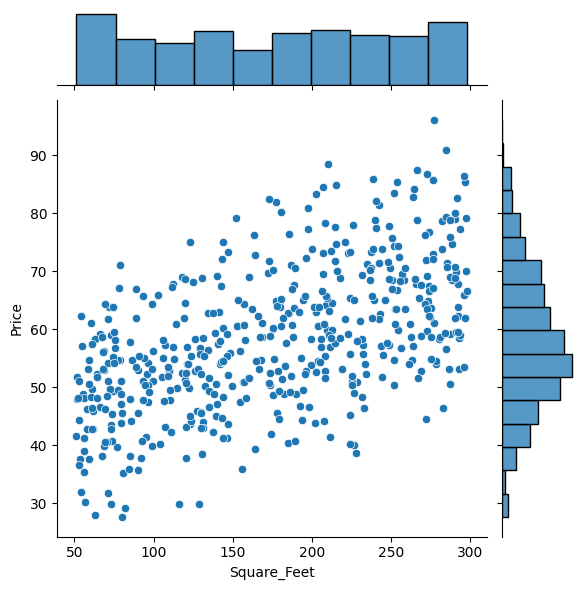

In [14]:
sns.jointplot(x="Square_Feet",y="Price",data=data)

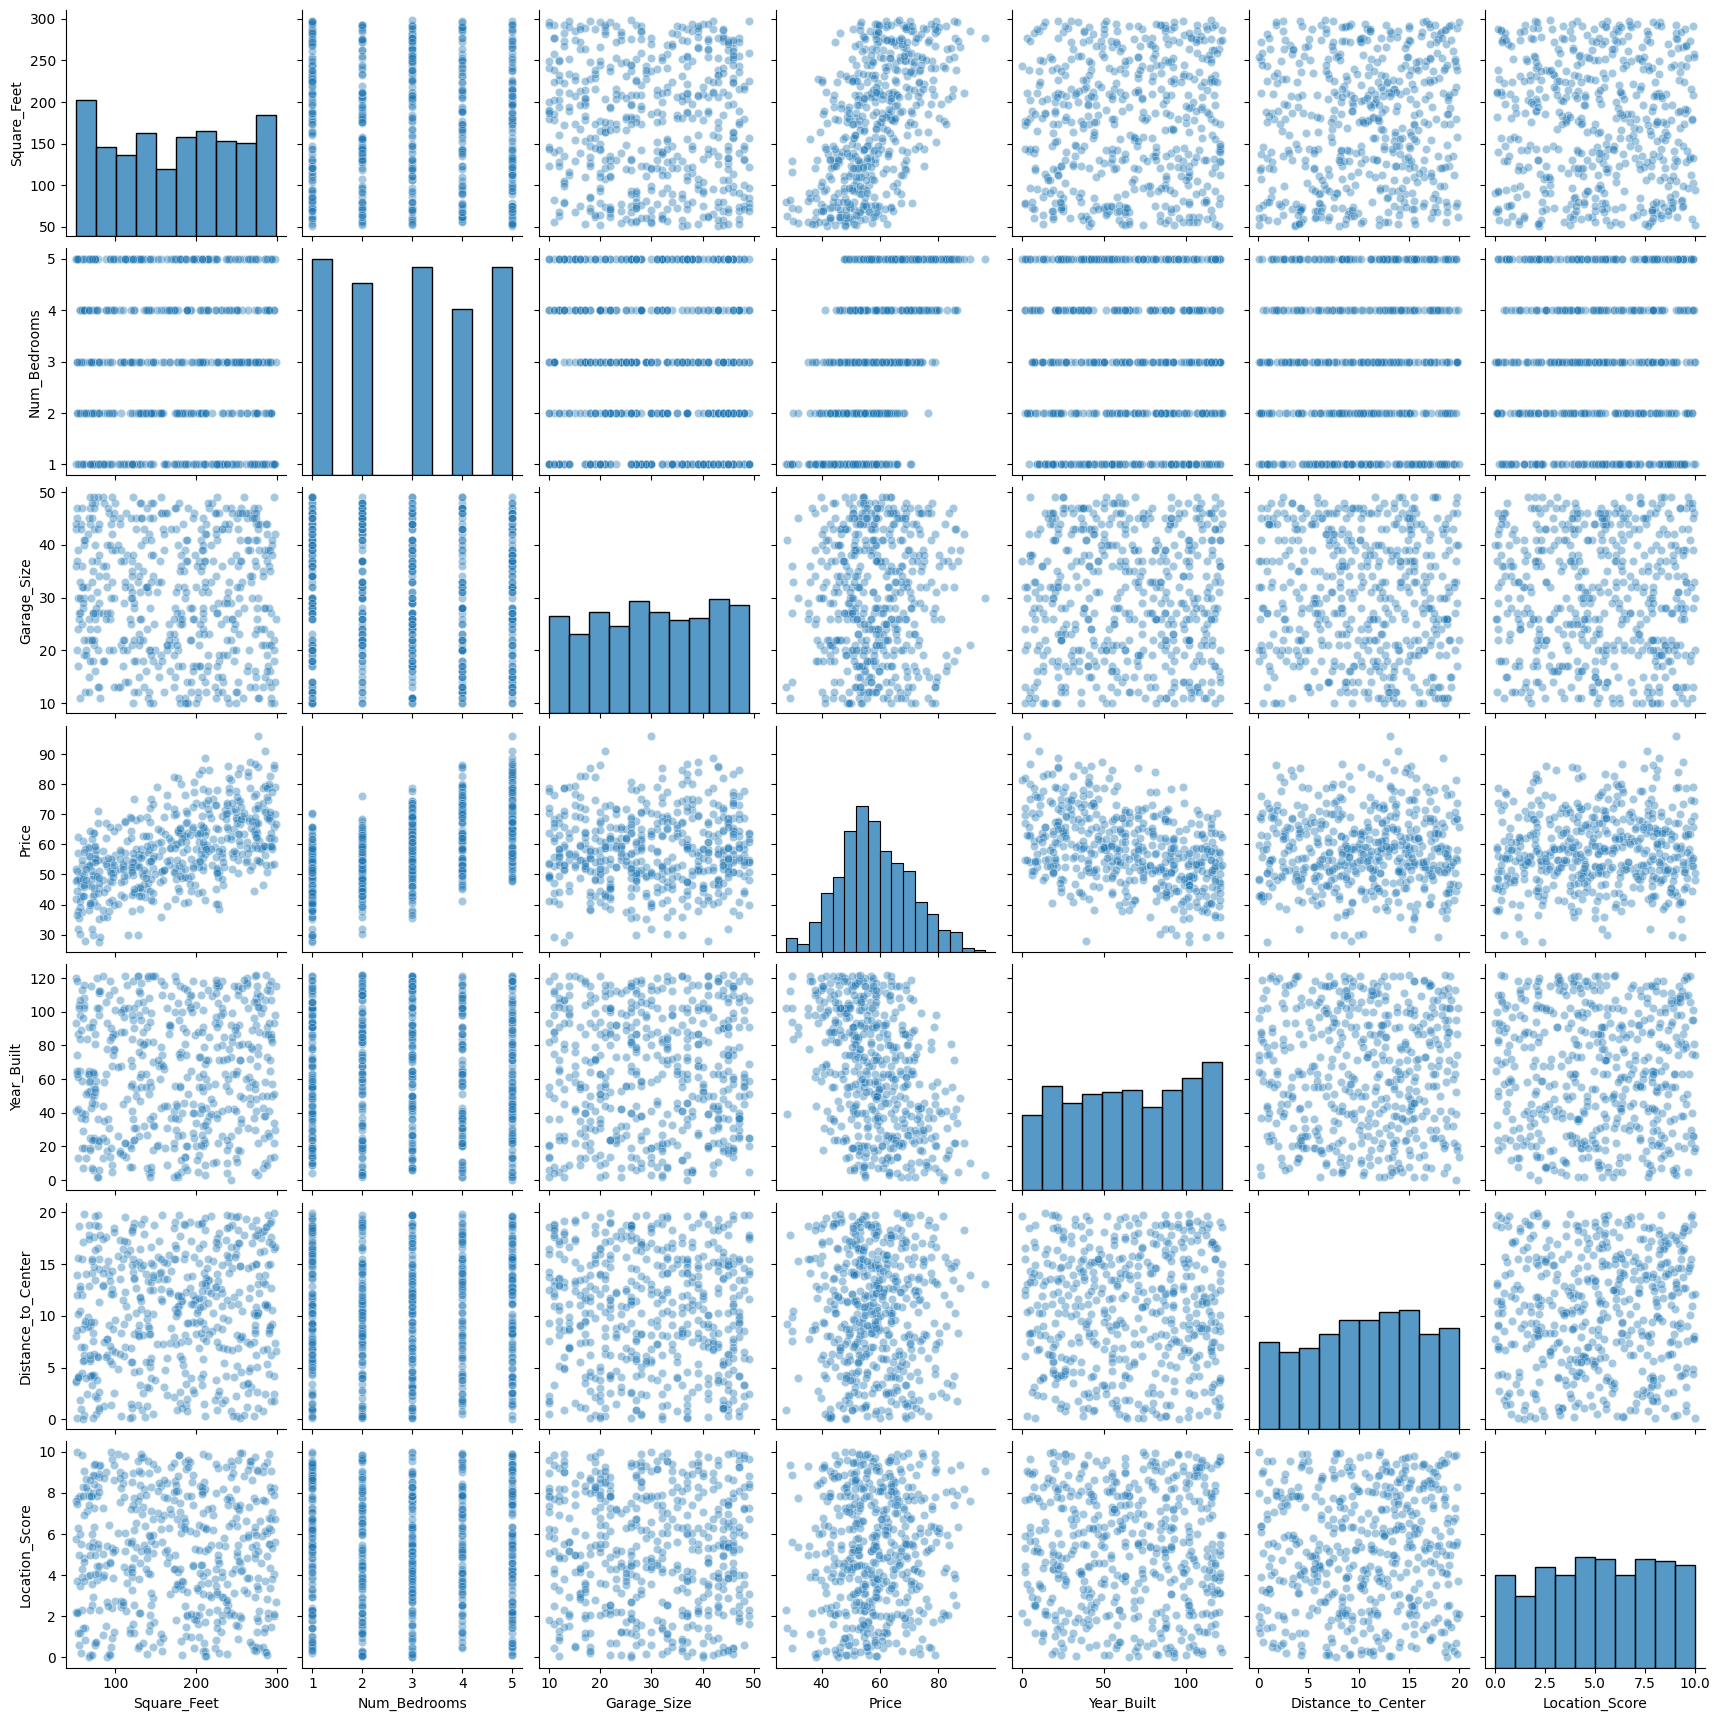

In [15]:
sns.pairplot(data[['Square_Feet','Num_Bedrooms','Garage_Size','Price','Year_Built','Distance_to_Center','Location_Score']],kind='scatter',plot_kws={"alpha":0.4})

In [16]:
#Remove column features
colonnes=colonnes.tolist()
colonnes.remove('ID')
colonnes.remove('Has_Garden')
colonnes.remove('Has_Pool')

In [17]:
colonnes

['Square_Feet',
 'Num_Bedrooms',
 'Num_Bathrooms',
 'Num_Floors',
 'Year_Built',
 'Garage_Size',
 'Location_Score',
 'Distance_to_Center',
 'Price']

Selected columns -> ['Year_Built', 'Square_Feet', 'Price', 'Num_Bedrooms']


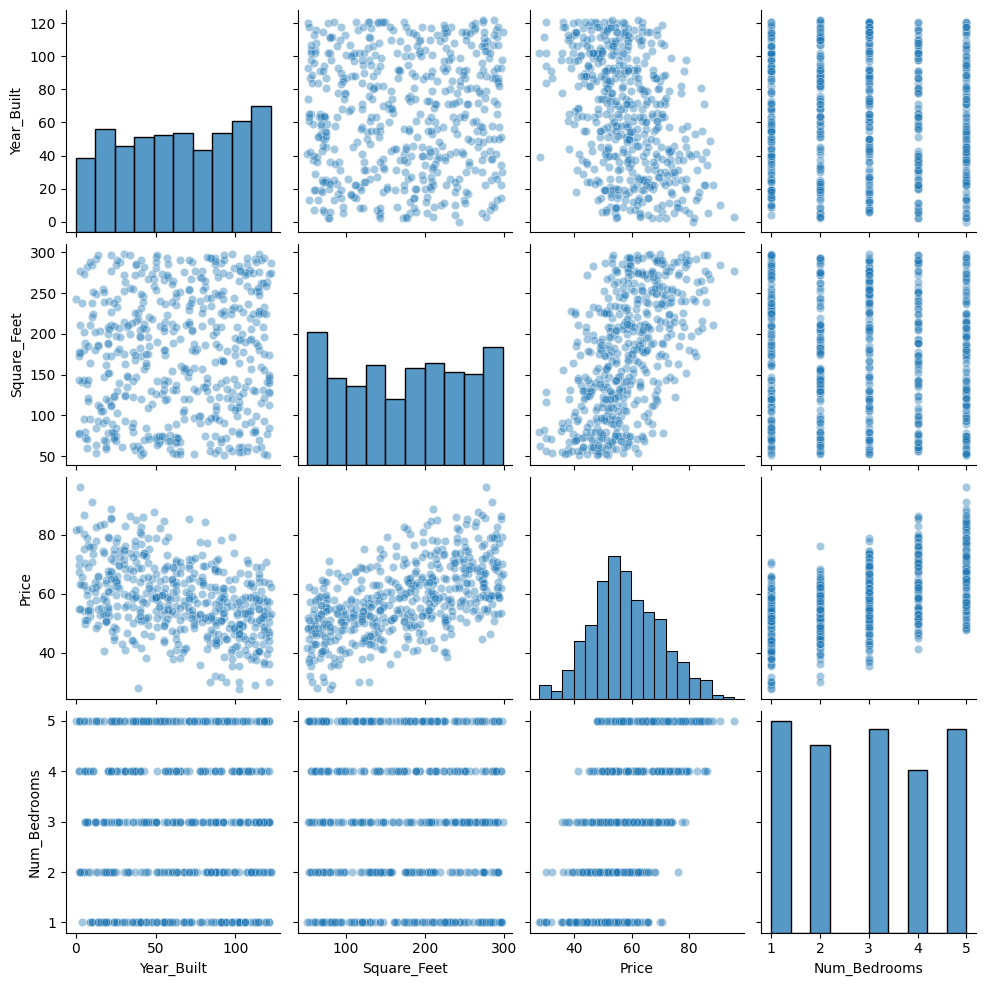

In [18]:
#Random selection of columns for analysis purposes.
random_colonnes=random.sample(colonnes,k=4)
print(f'Selected columns -> {random_colonnes}')
sns.pairplot(data[random_colonnes],kind='scatter',plot_kws={"alpha":0.4})

## Model training with Scikit-learn

Data splitting diagram. One part is used for training and the other for testing.

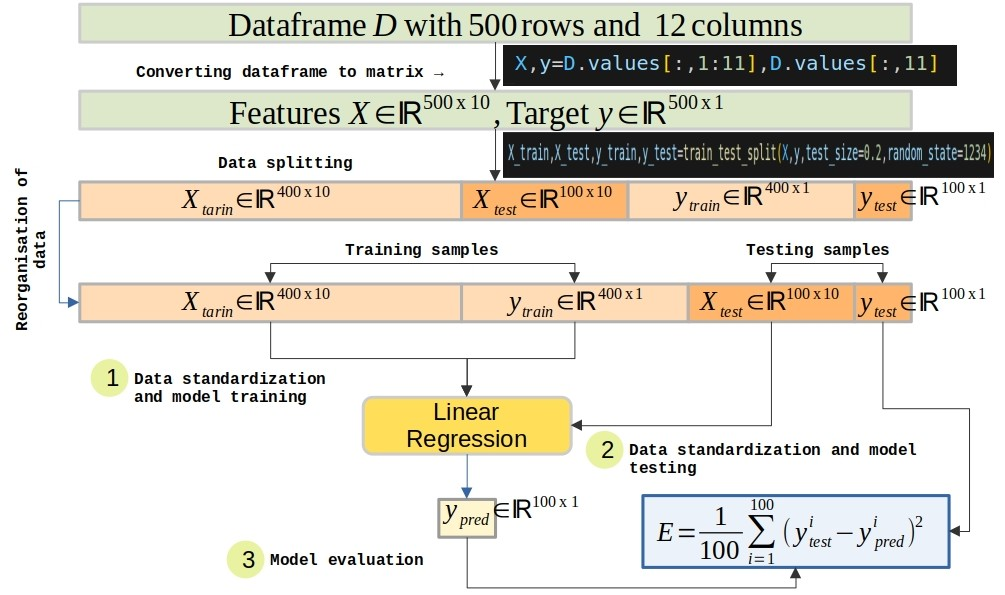

In [19]:
observations=['Square_Feet','Num_Bedrooms','Num_Floors','Year_Built','Distance_to_Center']
X=data[observations].values#Features
y=data[['Price']].values#Target

Standardisation

$X_{scaled} = \frac{X - \mu}{\sigma}$

$\mu$ is the mean and $\sigma$ the standard deviation.


In [20]:
print('Data point before standardisation.')
print(X[0])

scaler = StandardScaler()
X_ = scaler.fit_transform(X)#Standardisation
print('\n')
print('Data point after standardisation.')
print(X_[0])

Data point before standardisation.
[143.63502971   1.           3.          55.           5.93573364]


Data point after standardisation.
[-0.41563649 -1.36016965  1.29227295 -0.26500248 -0.81214901]


In [21]:
#Save the scaler object to standardise test data
joblib.dump(scaler, 'src/scaler.pkl')

['src/scaler.pkl']

In [22]:
#2% of the 100 samples are used for testing.
#By default the train_test_split function, splits the data randomly. random_state parameter allows reproduicing the data splitting scenario.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234)
X_train=scaler.fit_transform(X_train)#Standardise training data (only features).

### MLflow for expriment adn deployment tracking.

In [23]:
mlflow.end_run()#End the current run if any. 

In [24]:
mlflow.set_tracking_uri('http://127.0.0.1:8080')
mlflow.set_experiment('rent_prediction')
mlflow.start_run(run_name='my_model')

<ActiveRun: >

In [25]:
# mlflow.sklearn.autolog()
lr=LinearRegression(n_jobs=3)#Model initialization
lr.fit(X_train,y_train)#Training

#Standardise test data
X_test=scaler.transform(X_test)

pred=lr.predict(X_test)#Predictions

mse=mean_squared_error(y_test,pred)
print(f'Mean Squared Error (MSE) {mse}')
signature = infer_signature(X_test, lr.predict(X_test))
mlflow.log_metric("mse", mse)
#name-> Define the model version.
mlflow.sklearn.log_model(lr, name="model-v1",input_example=X_test[:5],signature=signature)
mlflow.log_artifact('src/scaler.pkl')#Register the scaler object to MLflow. It will be used to process inputs during the deployment phase.

Mean Squared Error (MSE) 18.835650706882188


In [26]:
mlflow.end_run()#End the current run if any. 

🏃 View run my_model at: http://127.0.0.1:8080/#/experiments/760535384223767729/runs/02acf522af7440fdad4043e13c443f48
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/760535384223767729


Etape à suivre pour visualiser et mettre à jour les info sur MLflow:  
- Copiez et collez cette url dans votre navigateur: http://127.0.0.1:8080
- Cliquez sur rent_prediction dans le panel experiment;
- Cliquez sur le nom de votre run;
- Dans le panel en dessous, vous trouverez tous les modèles enregistrés. Si nécessaire, cliquez sur le nom du modèle, puis sur le bouton enregister en haut à droite.
- La vue actuel vous permet d'ajouter des tags ou de définir le modèle de test/production.

## Performance Analysis

In [27]:
print(f'Shape of the prediction vector {pred.shape}')
print(f'Shape of the target vector {y_test.shape}')

#Concatenate the prediction and target to have a 100x2 matrix
#Convert this matrix in dataframe for comparison purposes
print(type(y_test))
pred_ytest=np.concatenate([pred,y_test],1)
df_test=pd.DataFrame(pred_ytest)
df_test.head(5)

Shape of the prediction vector (100, 1)
Shape of the target vector (100, 1)
<class 'numpy.ndarray'>


,0,1
0,62.363279,68.506587
1,49.462478,45.000750
2,61.146430,60.286122
3,76.481913,79.337051
4,76.880390,78.713157


In [28]:
df_test.rename(columns={0:"Prediction",1:"Target"},inplace=True)
df_test.head(10)

,Prediction,Target
0,62.363279,68.506587
1,49.462478,45.000750
2,61.146430,60.286122
3,76.481913,79.337051
4,76.880390,78.713157
5,65.844667,67.301059
6,53.379790,54.227621
7,48.938521,43.198846
8,54.245641,52.855749
9,63.102976,61.806247


## Results analysis

<Axes: xlabel='Prediction', ylabel='Target'>

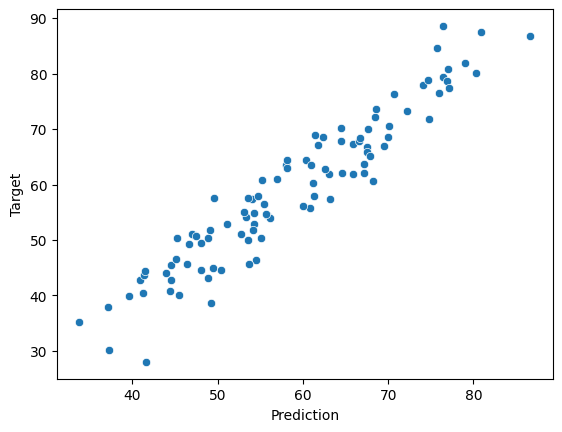

In [29]:
sns.scatterplot(df_test,x='Prediction',y='Target')

Let's code the Mean Squared error with numpy and see whether the result matches the one imported from sklearn

$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

In [30]:
error=mean_squared_error(y_test,pred)
print(f'Error {error}')

Error 18.835650706882188


In [31]:
#With numpy
error=np.sum(np.square(y_test-pred))/len(y_test)
print(f'Error {error}')

Error 18.835650706882188


## Results interpreation based on model weights

$lr=y=a_1x_1 + a_2x_2 + a_3x_3 + a_4x_4 + a_5x_5 + b$

$lr=y=a_1{Square\_Feet} + a_2{Num\_Bedrooms} + a_3{Num\_Floors} + a_4{Distance\_to\_Center} +a_5{Year\_Built}$ + b

In [32]:
print(f'Model coeficients {lr.coef_}')
print(f"Model's intercept {lr.intercept_}")

Model coeficients [[ 7.3518356   6.97981974  1.51027957 -5.08353764 -0.89932405]]
Model's intercept [58.04278145]


In [33]:
for index,obs in enumerate(observations):
    print(f'{obs} => {lr.coef_[0][index]}')

Square_Feet => 7.351835603317241
Num_Bedrooms => 6.979819741941862
Num_Floors => 1.5102795698824318
Year_Built => -5.083537637616926
Distance_to_Center => -0.8993240475197151



- A positive weight indicates that the higher the value of the associated feature, the higher the rent price.
- A negative weight indicates that the higher the value of the associated feature, the lower the rent price.
- The feature that increases the price the most is the one with a higher weight. In our case it's the squared_feet feature.


## Save model weights

In [34]:
np.save('weights/lr_coeficients',lr.coef_)
np.save('weights/lr_intercept',lr.intercept_)

In [35]:
#Load model weights
coeficients=np.load('weights/lr_coeficients.npy')
interecpt=np.load('weights/lr_intercept.npy')

In [36]:
lr_=LinearRegression(n_jobs=3)#Initialize the model
lr_.coef_=coeficients#Initialize the model coefficient with the saved ones
lr_.intercept_=interecpt#Initialize the model's intercept  with the saved one

In [37]:
print(f"Shape of one feature vector {X_test[0].shape}")
print(f"Feature reshaped {X_test[0].reshape(-1,X_test[0].shape[0]).shape}")

Shape of one feature vector (5,)
Feature reshaped (1, 5)


In [38]:
#Model inference based on saved weights
pred_=lr_.predict(X_test[0].reshape(-1,X_test[0].shape[0]))
print(pred_)

[[62.3632785]]


In [39]:
#Inference from the current model (without loading weights)
pred=lr.predict(X_test[0].reshape(-1,X_test[0].shape[0]))
print(pred)

[[62.3632785]]


We can see that the results are the same in both cells above.
This can be checked out as bellow:

In [40]:
assert pred_==pred, "Error"